<h1 style="text-align: center">
Deep Learning HW2 </br> 
Image Classification
</h1>

## Import needed libraries


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torch.utils.data.dataloader import DataLoader
from tqdm import tqdm
from sklearn.metrics import classification_report

## Loading and Pre-Processing data

In [2]:
## Download FashionMNIST dataset
# use fashion mnist dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_set = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)

In [3]:
# split training set into train and validation data
train_size = 48000
val_size = 60000 - train_size
train_ds, val_ds = random_split(dataset=train_set, lengths=[train_size, val_size])

In [4]:
# Loading the dataset into memory using Dataloader
# use your desired batch size and shuffle is necessary

batch_size = 64
train_dataloader = DataLoader(dataset=train_ds, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(dataset=val_ds, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=test_set, batch_size=batch_size)
classes = train_set.classes

**Display some images from dataset**

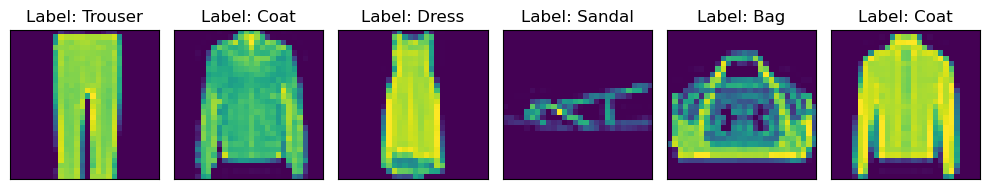

In [5]:
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)
fig, axes = plt.subplots(nrows=1, ncols=6, figsize=(10, 8), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,6),axes.flat):
    img,label=images[i],labels[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"Label: {classes[label]}")

plt.tight_layout()
plt.show()

# Defining the Convolutional Neural Network

<img src='https://drive.google.com/uc?id=1Euy5_bGIiiYECSZUeEofgTImJWgQ0XLf'>

**<h2>Implement the model above in pytorch</h2>**

In [6]:
import torch.nn as nn
import torch.nn.functional as F

#define the CNN architecture below
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2)
        
        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2)
        
        # Fully connected layers
        self.fc1 = nn.Linear(64 * 6 * 6, 128)  # 6x6 is the spatial size after two max-pooling layers
        self.relu3 = nn.ReLU()
        self.fc2 = nn.Linear(128, 10)  # 10 classes for FashionMNIST

    def forward(self, x):
        # Forward pass through the first convolutional layer
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.maxpool1(x)
        
        # Forward pass through the second convolutional layer
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)
        
        # Flatten the output from the previous layer
        x = x.view(x.size(0), -1)
        
        # Forward pass through fully connected layers
        x = self.fc1(x)
        x = self.relu3(x)
        x = self.fc2(x)

        return x

In [7]:
# Using GPU if it's available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [8]:
cnn_model = Net()
cnn_model.to(device)

Net(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (relu1): ReLU()
  (maxpool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2304, out_features=128, bias=True)
  (relu3): ReLU()
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

# Defining Loss Function and optimizer
**Define appropriate Loss Function, Optimizer and Learning Rate**

In [9]:
# Define appropriate Loss Function, Optimizer and Learning Rate

import torch.optim as optim

Learning_rate = 0.001

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.Adam(cnn_model.parameters(), lr=Learning_rate)


**Define number of epochs and path to save the best model**

In [10]:
epochs = 10
# save_path="./content/cnn_model"
save_path="./cnn_model"

# Finally we will train our neural network

In [11]:
# multiclass accuracy
def multi_acc(y_pred, y_test):
    _, y_pred_tags = torch.max(y_pred, dim = 1)    
    correct_pred = (y_pred_tags == y_test).float()
    acc = correct_pred.sum() / len(correct_pred)
    acc = torch.round(acc * 100)
    return acc

**Implementing the training algorithm and Saving the model with minimum Validation Loss**

In [12]:
# Implementing the training algorithm and Saving the mode with minimum Validation Loss
# training loop
def train_model(model=cnn_model, train_dataloader=train_dataloader,
                val_dataloader=val_dataloader, optimizer=optimizer,
                criterion=criterion, save_path=save_path,
                device=device, n_epochs = 10):
    
    train_losses = []
    val_losses = []
    valid_loss_min = np.Inf 

    for epoch in range(n_epochs):
        
        ####### Training Phase ########
        model.train()
        with tqdm(train_dataloader, unit="batch") as batches:
            epoch_loss = 0
            for data, target in batches:
                batches.set_description(f"Epoch {epoch + 1}")
                # move to GPU
                data, target = data.to(device), target.to(device)
            
                # train 
                optimizer.zero_grad()
                out = model(data)
                loss = criterion(out, target)
                loss.backward()
                optimizer.step()
                
                # train_loss =
                epoch_loss += loss.item()
                acc = multi_acc(out, target)
                batches.set_postfix(train_loss = loss.item(), train_accuracy = acc.item()) # show loss and accuracy per batch of data
        train_losses.append(epoch_loss)


        ####### Validation Phase ########
        model.eval()
        valid_loss = 0.0
        with torch.no_grad():
            # run the prediction on the validation dataloader,
            # y_true, y_pred = [], []
            for batch_idx, (data, target) in enumerate(val_dataloader):
                # move to GPU
                data, target = data.to(device), target.to(device)
                
                # validation
                out = model(data)
                valid_loss += criterion(out, target)

        val_losses.append(float(valid_loss.to("cpu")))
        
        # print validation statistics 
        print('Epoch: {}  Validation Loss: {:.6f}'.format(epoch+1, valid_loss))

        ## If the valiation loss has decreased, then saving the model
        if valid_loss <= valid_loss_min:
            print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
            valid_loss_min,
            valid_loss))
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss 

    return model, train_losses, val_losses

**Train the model**

In [16]:
model, train_losses, val_losses = train_model()

Epoch 1: 100%|██████████| 750/750 [00:41<00:00, 18.04batch/s, train_accuracy=100, train_loss=0.0239] 


Epoch: 1  Validation Loss: 55.153122
Validation loss decreased (inf --> 55.153122).  Saving model ...


Epoch 2: 100%|██████████| 750/750 [00:36<00:00, 20.70batch/s, train_accuracy=95, train_loss=0.0885]  


Epoch: 2  Validation Loss: 53.842190
Validation loss decreased (55.153122 --> 53.842190).  Saving model ...


Epoch 3: 100%|██████████| 750/750 [00:35<00:00, 21.02batch/s, train_accuracy=100, train_loss=0.0159] 


Epoch: 3  Validation Loss: 59.758785


Epoch 4: 100%|██████████| 750/750 [00:38<00:00, 19.31batch/s, train_accuracy=98, train_loss=0.0385]  


Epoch: 4  Validation Loss: 63.340282


Epoch 5: 100%|██████████| 750/750 [00:35<00:00, 21.20batch/s, train_accuracy=98, train_loss=0.0445]   


Epoch: 5  Validation Loss: 67.746513


Epoch 6: 100%|██████████| 750/750 [00:36<00:00, 20.78batch/s, train_accuracy=97, train_loss=0.067]    


Epoch: 6  Validation Loss: 72.212280


Epoch 7: 100%|██████████| 750/750 [00:35<00:00, 20.89batch/s, train_accuracy=95, train_loss=0.0972]   


Epoch: 7  Validation Loss: 73.514030


Epoch 8: 100%|██████████| 750/750 [00:35<00:00, 20.85batch/s, train_accuracy=97, train_loss=0.0429]   


Epoch: 8  Validation Loss: 80.380150


Epoch 9: 100%|██████████| 750/750 [00:35<00:00, 21.00batch/s, train_accuracy=98, train_loss=0.0523]   


Epoch: 9  Validation Loss: 80.124977


Epoch 10: 100%|██████████| 750/750 [00:40<00:00, 18.70batch/s, train_accuracy=100, train_loss=0.00281] 


Epoch: 10  Validation Loss: 87.733231


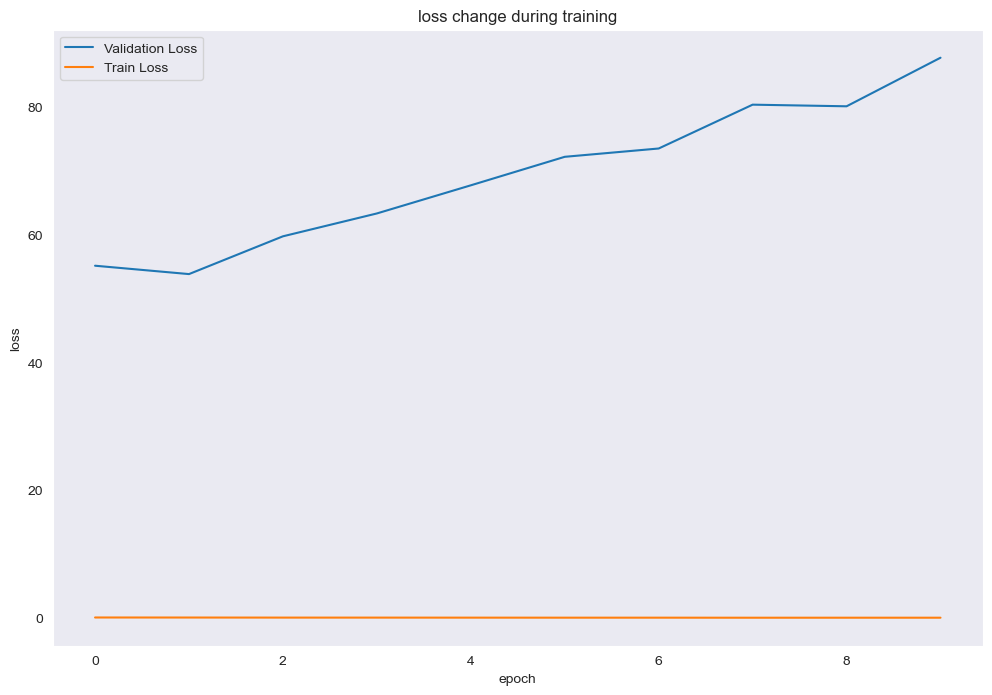

In [17]:
# plot losses
plt.subplots(figsize=(12, 8))
sns.set_style("dark")
sns.lineplot(data=val_losses,label="Validation Loss")
sns.lineplot(data=np.asarray(train_losses)/1000,label="Train Loss").set(title="loss change during training", xlabel="epoch", ylabel="loss")
plt.legend()
plt.show()

# Prediction on Test Data

In [18]:
def predict(images, model): 
    # Set the model to evaluation mode
    model.eval()

    # Ensure the input images are on the same device as the model's parameters
    images = images.to(next(model.parameters()).device)

    # Perform inference (forward pass) to get predictions
    with torch.no_grad():
        outputs = model(images)

    # Get the class predictions (index of the highest probability)
    _, predicted = torch.max(outputs, 1)

    return predicted

**Accuracy Result on Test Data**

In [19]:
correct = 0
total = 0
y_pred_list = []
y_true_list = []
model.eval()
with torch.no_grad():
    for data in test_dataloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)  # Move data to the appropriate device

        # Get model predictions for the batch
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)

        # Accumulate total and correct predictions
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Append predicted and true labels to lists
        y_pred_list.extend(predicted.cpu().numpy())
        y_true_list.extend(labels.cpu().numpy())

        # for  x in predicted.cpu().numpy(): y_pred_list.append(x)
        # for  x in labels.cpu().numpy(): y_true_list.append(x)

print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))

Accuracy of the network on the 10000 test images: 97 %


**Classification report**

In [20]:
print(classification_report(y_true_list, y_pred_list, target_names=classes))

              precision    recall  f1-score   support

 T-shirt/top       0.96      0.97      0.97      6000
     Trouser       1.00      1.00      1.00      6000
    Pullover       0.94      0.98      0.96      6000
       Dress       0.98      0.98      0.98      6000
        Coat       0.98      0.93      0.96      6000
      Sandal       0.99      1.00      0.99      6000
       Shirt       0.95      0.94      0.95      6000
     Sneaker       0.98      0.99      0.99      6000
         Bag       1.00      1.00      1.00      6000
  Ankle boot       0.99      0.98      0.99      6000

    accuracy                           0.98     60000
   macro avg       0.98      0.98      0.98     60000
weighted avg       0.98      0.98      0.98     60000



**Displaying a random set of images from test data**

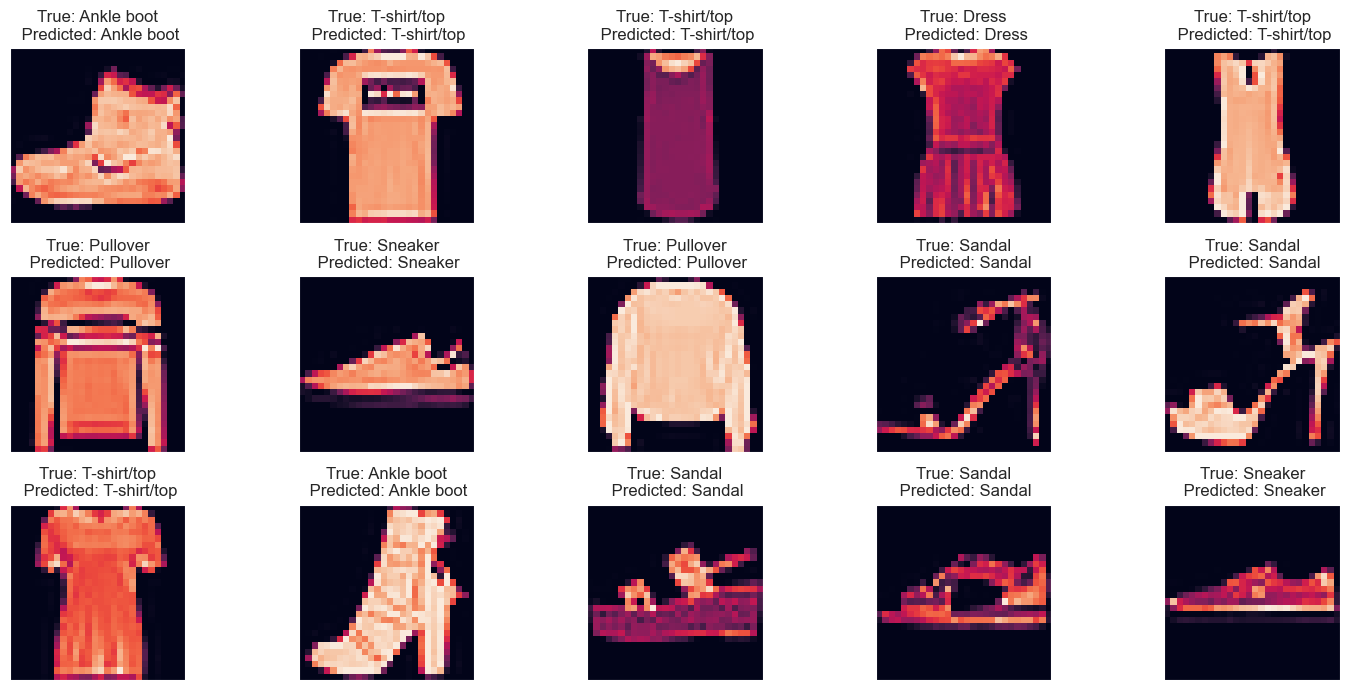

In [22]:
dataiter = iter(test_dataloader)
images, labels = next(dataiter)
predicted=predict(images,cnn_model)

fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(15, 7), subplot_kw={'xticks': [], 'yticks': []})
for i,ax in zip(range(0,16),axes.flat):
    img,label=images[i],labels[i]
    pred=predicted[i]
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(f"True: {classes[label]}\n Predicted: {classes[pred]}")

plt.tight_layout()
plt.show()